In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib

from MieSppForce import frenel, dipoles, green_func, force

In [2]:
plt.rcParams.update({'font.size': 14})

In [3]:

eps_Au = frenel.get_interpolate('Au')
eps_Si = frenel.get_interpolate('Si')

wl=800
dist = 2
STOP=45
angle=25*np.pi/180
phase=0
a_angle = np.pi/4

R = np.linspace(50,120,60)
F_x = np.empty((len(R), 8))
F_y = np.empty_like(F_x)
F_z = np.empty_like(F_x)


for i in tqdm(range(len(R))):
    point = [0,0,dist+R[i]]
    f =  force.F(wl, eps_Au, point, R[i], eps_Si, angle,amplitude=1,phase=phase,a_angle=a_angle, stop=STOP, full_output=True)
    F_x[i,:] = f[0]
    F_y[i,:] = f[1]
    F_z[i,:] = f[2]

  0%|          | 0/60 [00:00<?, ?it/s]c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:441: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
100%|██████████| 60/60 [02:28<00:00,  2.47s/it]


In [4]:
P,M = np.empty((len(R),3), dtype=complex),np.empty((len(R),3), dtype=complex)

for i in tqdm(range(len(R))):
    point = [0,0, dist+R[i]]
    p,m = dipoles.calc_dipoles_v2(wl, eps_Au, point, R[i], eps_Si, angle, amplitude=1, phase=phase, a_angle=a_angle, stop=STOP)
    p,m = p[:,0],m[:,0]
    P[i,:],M[i,:]=p,m

100%|██████████| 60/60 [00:00<00:00, 2214.33it/s]


In [5]:
dyGE_yz = np.zeros(len(R), dtype=complex)
dyGH_yz,dyrotGHxz,dyrotGHzx = np.empty_like(dyGE_yz),  np.empty_like(dyGE_yz), np.empty_like(dyGE_yz)

for i in tqdm(range(len(R))):
    z0=dist+R[i]
    dyGE, dyGH = green_func.dy_green_E_H(wl, z0, eps_Au, STOP)
    dyrotGE, dyrotGH = green_func.dy_rot_green_E_H(wl, z0, eps_Au, STOP)
    dyGE_yz[i] = dyGE[1,2]
    dyGH_yz[i] = dyGH[1,2]
    dyrotGHxz = dyrotGH[0,2]
    dyrotGHzx = dyrotGH[2,0]

100%|██████████| 60/60 [00:00<?, ?it/s]


In [6]:
GExx, GEzz, GHxx, GHzz = np.empty_like(dyGE_yz),  np.empty_like(dyGE_yz), np.empty_like(dyGE_yz), np.empty_like(dyGE_yz)
rotGExy, rotGEyx = np.empty_like(dyGE_yz), np.empty_like(dyGE_yz)

for i in tqdm(range(len(R))):
    z0=dist+R[i]
    GE, GH = green_func.green_ref_00(wl, z0, eps_Au, STOP)
    rotGE, _  = green_func.rot_green_ref_00(wl, z0, eps_Au, STOP)
    GExx[i] = GE[0,0]
    GEzz[i] = GE[2,2]
    GHxx[i] = GH[0,0]
    GHzz[i] = GH[2,2]

    rotGExy[i] = rotGE[0,1]
    rotGEyx[i] = rotGE[1,0]

100%|██████████| 60/60 [00:00<00:00, 152427.76it/s]


In [36]:
c_const = 299792458
eps0_const = 1/(4*np.pi*c_const**2)*1e7
mu0_const = 4*np.pi * 1e-7
k = 2*np.pi/wl/1e-9
omega = 2*np.pi*c_const/wl/1e-9
kz = 2*np.pi/wl * np.cos(angle)

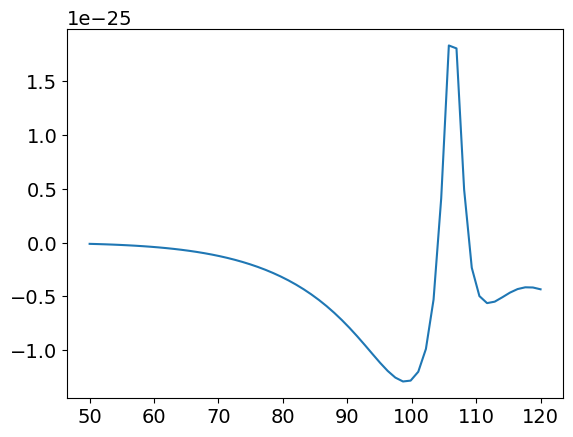

In [7]:
plt.plot(R, F_y[:,0])

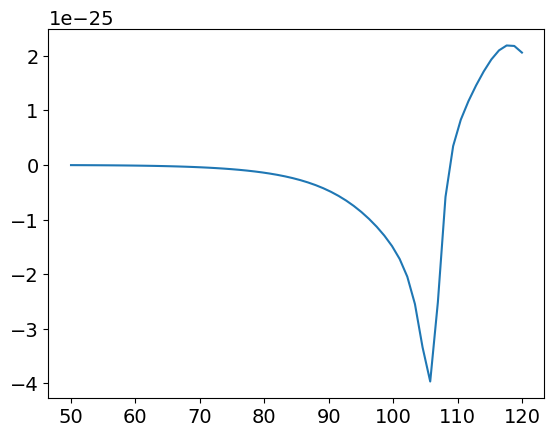

In [11]:
plt.plot(R, F_y[:,3]+F_y[:,6])

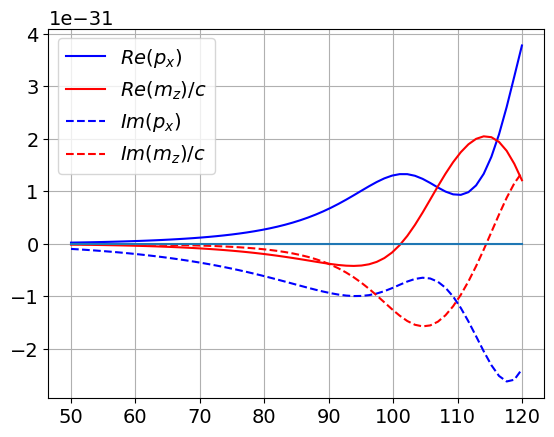

In [ ]:
plt.plot(R, np.real(P[:,0]), label='$Re(p_x)$', c='b')
plt.plot(R, np.real(M[:,1])/c_const, label='$Re(m_z)/c$', c='r')
plt.plot(R, np.imag(P[:,0]), label='$Im(p_x)$', c='b', ls='--')
plt.plot(R, np.imag(M[:,1])/c_const, label='$Im(m_z)/c$', c='r', ls='--')

plt.grid()
plt.legend()
plt.show()

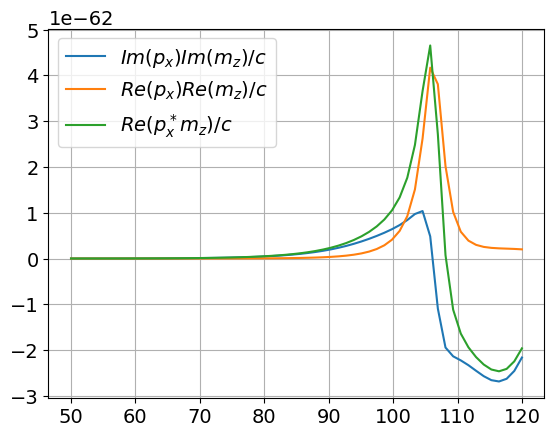

In [ ]:
plt.plot(R, np.imag(P[:,0])*np.imag(M[:,2])/c_const, label='$Im(p_x)Im(m_z)/c$')
plt.plot(R, np.real(P[:,0])*np.real(M[:,2])/c_const, label='$Re(p_x)Re(m_z)/c$')
plt.plot(R, np.real(P[:,0].conj() * M[:,2])/c_const, label='$Re(p_x^* m_z)/c$')
plt.legend()
plt.grid()
plt.show()

In [35]:
alphaE, alphaH =  np.empty_like(dyGE_yz),  np.empty_like(dyGE_yz)
r_p, r_s = frenel.reflection_coeff_v2(wl, eps_Au, angle)

for i in tqdm(range(len(R))):
    z0 = dist + R[i]
    alphaE[i], alphaH[i] = dipoles.alpha_v2(wl, R[i], eps_Si)

100%|██████████| 60/60 [00:00<00:00, 9944.21it/s]


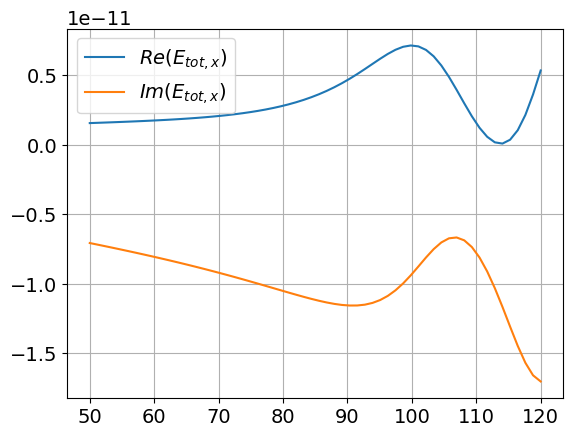

In [47]:
plt.plot(R, np.real(P[:,0]/alphaE), label='$Re(E_{tot,x})$')
plt.plot(R, np.imag(P[:,0]/alphaE), label='$Im(E_{tot,x})$')
plt.legend()
plt.grid()
plt.show()

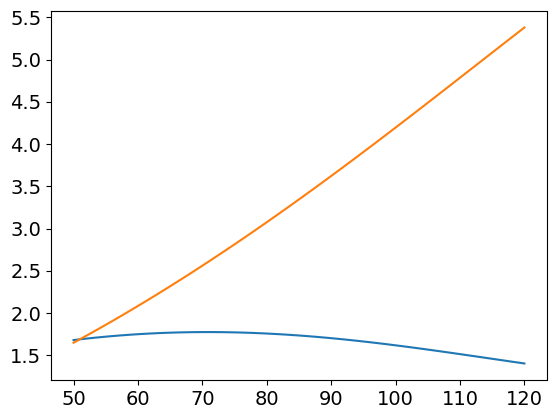

In [42]:
plt.plot(R, np.imag(1+r_s.conj() * np.exp(-2j*kz*(dist+R) - r_p * np.exp(2j*kz*(dist+R)) - r_p*r_s.conj())))
plt.plot(R, np.real(1+r_s.conj() * np.exp(-2j*kz*(dist+R) - r_p * np.exp(2j*kz*(dist+R)) - r_p*r_s.conj())))

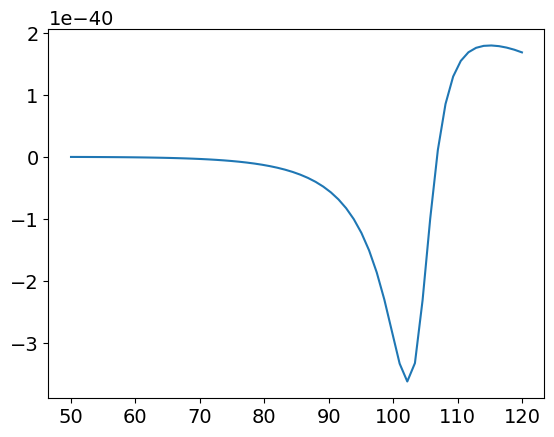

In [48]:
plt.plot(R, -np.real(alphaE * alphaH.conj()))

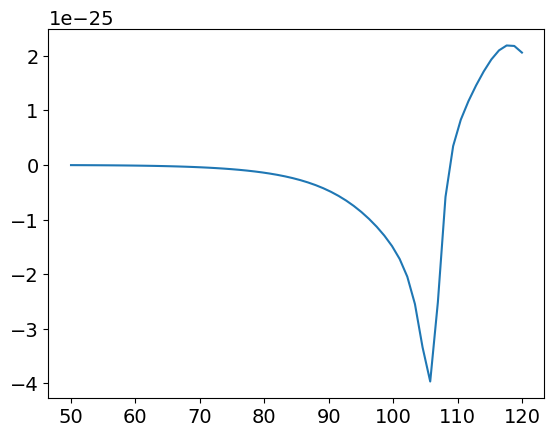

In [49]:
plt.plot(R, F_y[:,3]+F_y[:,6])

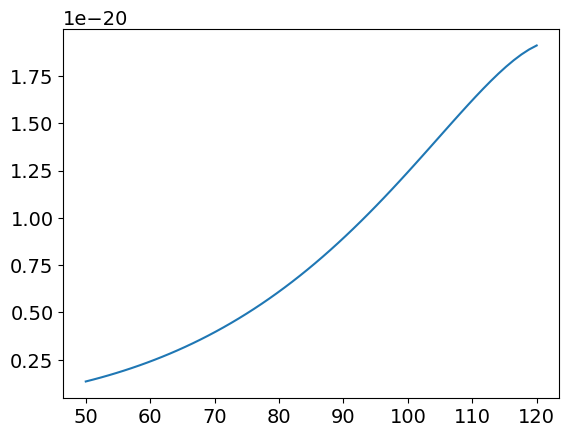

In [45]:
plt.plot(R, np.real(alphaE))